## 正定値カーネルの例
$x'$を固定して、$y=k(x,x')$をプロットした。

plt.figure(figsize = (12,8))
RBF (Gaussian), Matern, RationalQuadraticのカーネル関数については$x'=0$に固定、DotProductのカーネル関数については$x'= -1.0, 0.0, 1.0$の時についてプロットした。

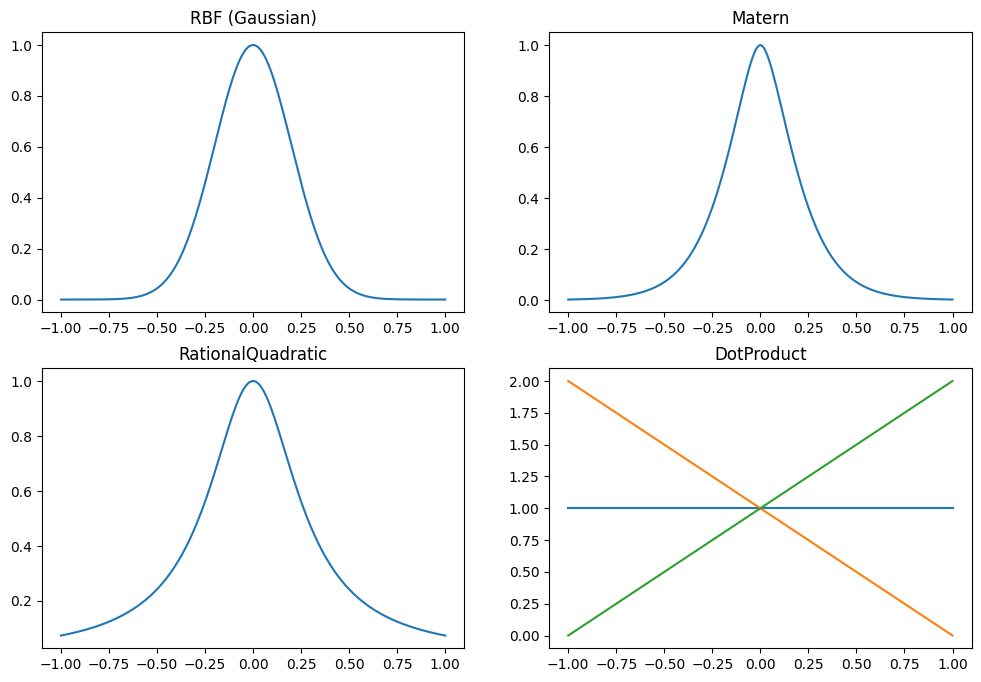

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import eig

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct

np.random.seed(1)

# データ点を用意
x = np.linspace(-1.0, 1.0, num=201)
x = np.atleast_2d(x).T # 要素の個数は同じだが、二次元配列の形式にして転置しておく

# カーネルの種類
kernel_list = [RBF, Matern, RationalQuadratic, DotProduct]

# カーネルの名前
kernel_name = ["RBF (Gaussian)", "Matern", "RationalQuadratic", "DotProduct"]

plt.figure(figsize = (12,8))

# 4種類のカーネルについて共分散行列を計算し、k(x,x')の一部をプロットする
index = 0
for kernel in kernel_list:
  plt.subplot(2,2,index+1)

  # 共分散行列の計算をする
  if kernel != DotProduct:
    C = kernel(length_scale=0.2).__call__(x,x) # length_scale=0.2はカーネル関数のハイパーパラメータ
    plt.plot(x,C[:,100]) # x'= 0
  else:
    C = kernel(sigma_0=1.0).__call__(x,x) # sigma_0=1.0はカーネル関数のハイパーパラメータ
    plt.plot(x,C[:,100]) # x'= 0
    plt.plot(x,C[:,0]) # x'= -1.0
    plt.plot(x,C[:,200]) # x'= 1.0




  plt.title('{}'.format(kernel_name[index]))

  index += 1

plt.show()



### カーネルをヒートマップで表示

$k(x,x')を$x,x'$平面のヒートマップで表示すると以下の通り。ここで$x'$を固定したときの断面が上でのグラフに対応する。

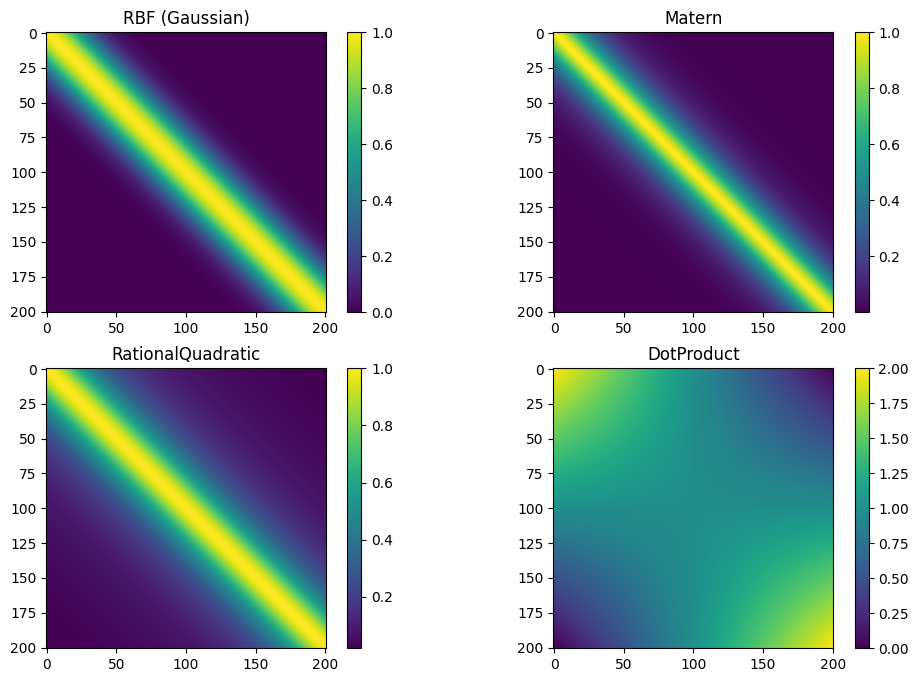

In [3]:
plt.figure(figsize = (12,8))

index = 0


for kernel in kernel_list:
  if kernel != DotProduct:
    C = kernel(length_scale=0.2).__call__(x,x)
  else:
    C = kernel(sigma_0=1.0).__call__(x,x)

  plt.subplot(2,2,index+1)
  plt.imshow(C) #ヒートマップとして表示
  plt.colorbar()
  plt.title('{}'.format(kernel_name[index]))

  index += 1

plt.show()


## ガウス過程事前分布からの関数のサンプリング



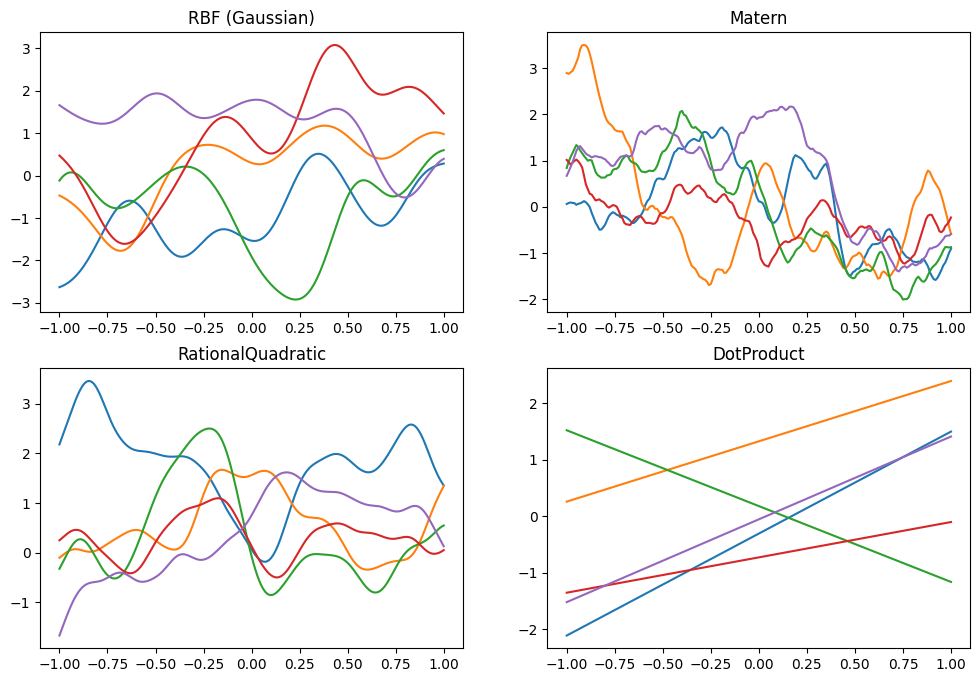

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import eigh

# 乱数の初期化
rng = np.random.default_rng(1)

# データ点
x = np.linspace(-1.0, 1.0, num=201)
x = np.atleast_2d(x).T # 2次元ベクトルとして扱うように変換した

plt.figure(figsize=(12,8))


index = 0

for kernel in kernel_list:
  if kernel != DotProduct:
    C = kernel(length_scale = 0.2).__call__(x,x) # 共分散を計算
  else:
    C = kernel(sigma_0 = 1.0).__call__(x,x) # 共分散を計算


  # 共分散行列の固有値分解
  lamb, U = eigh(C)

  #数値誤差で負の固有値が発生した場合の処理
  if min(lamb) < 0:
    lamb = lamb - min(lamb) + 1.0e-8

  plt.subplot(2,2, index+1)
  number = 5
  for n in range(number):
    y = U@(np.diag(np.sqrt(lamb))@rng.standard_normal((len(x),1)))
    plt.plot(x,y)
  plt.title(kernel_name[index])
  index += 1

plt.show()

## ガウス過程による回帰

$y=\sin(2\pi x)$, $t = y + \epsilon$ ($t \sim \mathcal N(0, 0.2^2)$)

これをもとにランダムに生成した10個の$x$の入力点とその出力値に基づいてガウス過程による回帰を行う。


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


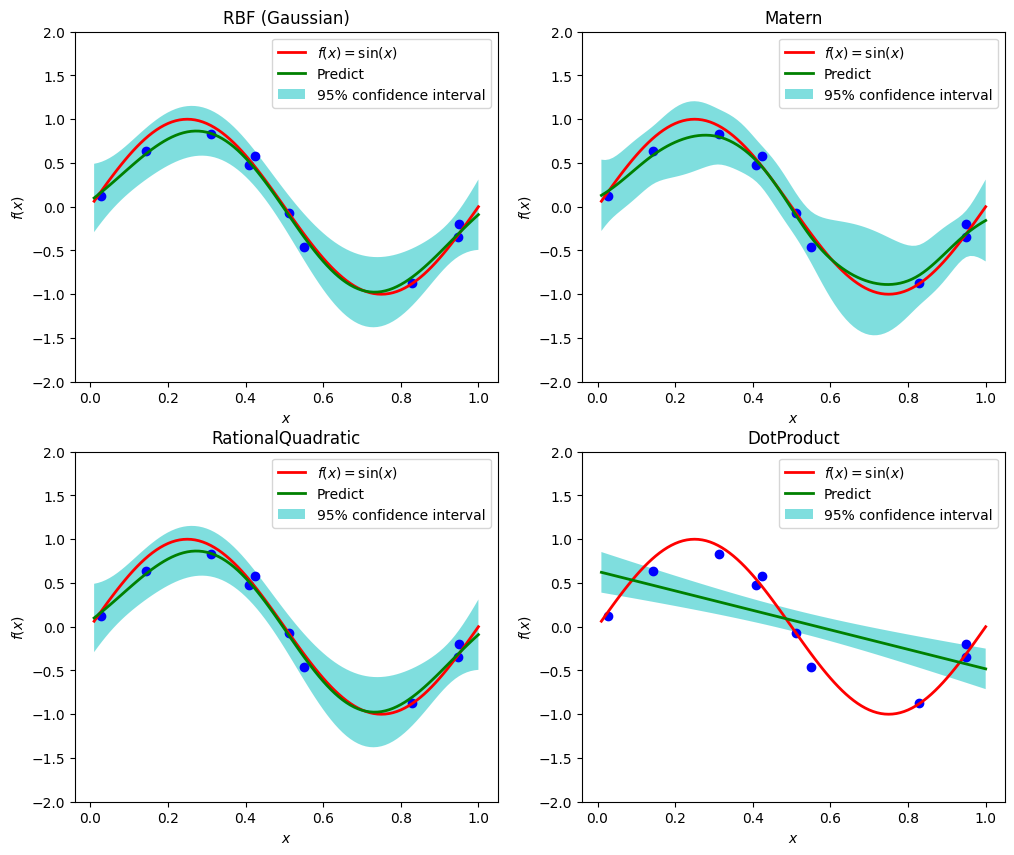

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct
from sklearn. metrics.pairwise import laplacian_kernel

def f(x):
  return np.sin(2 * np.pi * x)


# ガウシアンノイズ
sig0 = 0.2

# 乱数の初期化
rng = np.random.default_rng(1)

# データの生成
x_train = rng.random(10)
x_train = np.atleast_2d(x_train).T

y_train = f(x_train) + sig0 * rng.standard_normal((len(x_train),1))

x_test = np.array([i/100 for i in range(1,101)])
x_test = np.atleast_2d(x_test).T



plt.figure(figsize = (12,10))

index = 0
for kernel in kernel_list:
  # ガウス過程モデルの設定
  gp = GaussianProcessRegressor(kernel=kernel(), alpha= sig0 **2, n_restarts_optimizer=10) # インスタンスの作成。alphaは観測データに含まれるノイズの分散。n_restarts_optimizerはハイパーパラメータを最適化する際の再スタート回数
  # 最尤法でフィッティングしてハイパーパラメータを決定
  gp.fit(x_train,y_train)

  # x_testで予測値を評価
  y_pred, sigma = gp.predict(x_test, return_std= True)


  plt.subplot(2,2, index+1)
  plt.plot(x_train, y_train, 'o', color='b')
  plt.plot(x_test, f(x_test), 'r-', linewidth=2, label='$f(x)=\sin(x)$')
  plt.plot(x_test, y_pred, 'g-', linewidth=2, label='Predict' )
  plt.fill(np.concatenate([x_test,x_test[::-1]]),
           np.concatenate([y_pred.flatten() - 1.9600 * sigma,
                          (y_pred.flatten() + 1.9600 * sigma)[::-1]]), alpha = 0.5, fc = 'c', ec = 'None', label='95% confidence interval') # 塗りつぶし
  plt.xlabel('$x$')
  plt.ylabel('$f(x)$')
  plt.ylim(-2.0,2.0)
  plt.title(kernel_name[index])
  plt.legend()


  index += 1

plt.show()



## ガウス過程による分類

2クラス分類問題を扱う。
二次元空間内の$\mathbf{x}$を3つのガウス分布から各40点ずつ生成した。

$c_1 = (-1,0), c_2 =(1,0), c_3=(0, \sqrt{3})$としてガウシアンは以下の通り。

$p_1(\mathbf{x}) = \mathcal{N}(\mathbf{x}|c_1, 0.25)$

$p_2(\mathbf{x}) = \mathcal{N}(\mathbf{x}|c_2, 0.25)$

$p_3(\mathbf{x}) = \mathcal{N}(\mathbf{x}|c_3, 0.25)$

$p_1(\mathbf{x})$から生成された$\mathbf{x}$にはラベル$y=0$

$p_2(\mathbf{x}),p_3(\mathbf{x})$から生成された$\mathbf{x}$にはラベル$y=1$

を対応させる。

これらのデータをガウス過程を用いて分類する。


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


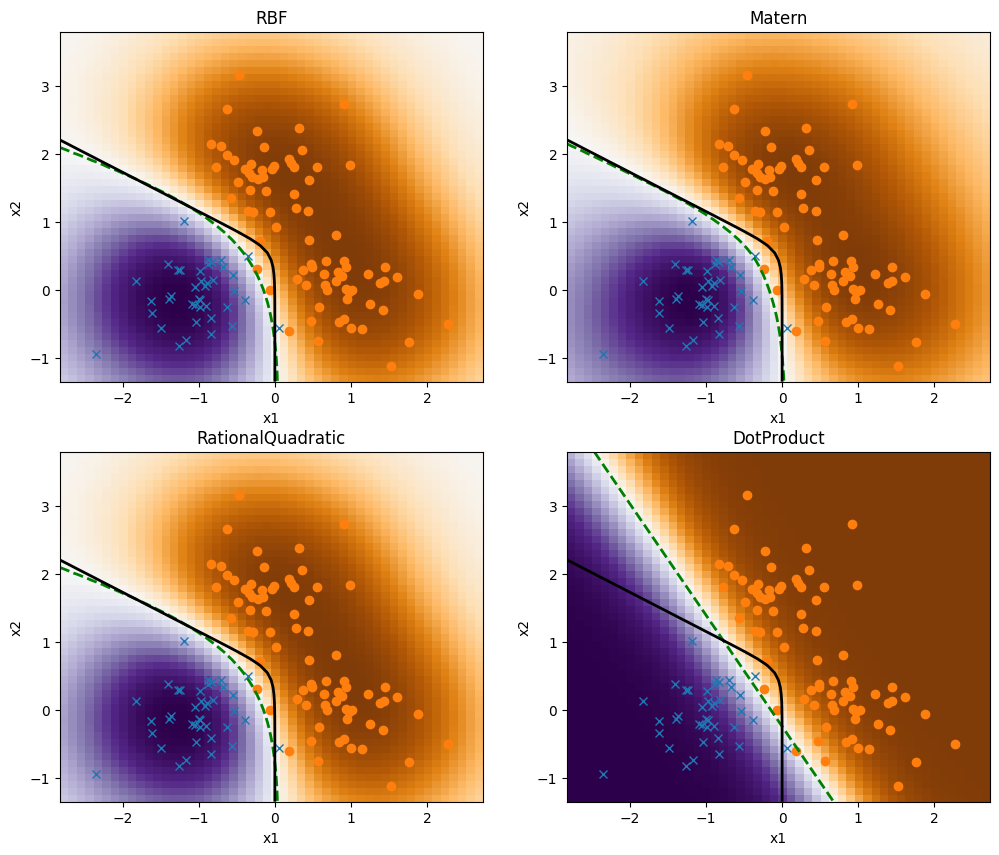

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, sqrt

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct

# 確率p(y=1|x)を与える関数の定義
def prob_true(x):
  a =  exp(-beta/2*np.linalg.norm(x-c1, axis=1)**2)
  b =  exp(-beta/2*np.linalg.norm(x-c2, axis=1)**2)
  c =  exp(-beta/2*np.linalg.norm(x-c3, axis=1)**2)
  return (b+c)/(a+b+c)

# 乱数の初期化
rng = np.random.default_rng(1)


# サンプルデータの生成

beta = 1/0.5 ** 2 # betaは精度。標準偏差は0.5
N = 120 # データの数
c1 = np.atleast_2d(np.array([-1,0]))
c2 = np.atleast_2d(np.array([1,0]))
c3 = np.atleast_2d(np.array([0, sqrt(3)]))

x_train = (1./sqrt(beta)) * rng.standard_normal((N,2)) # 標準偏差1/sqrt(beta)のガウス分布ガウンに従う二次元での点をN個生成。N*2の形でデータを持っている

x_train[:int(N/3), :] += c1 # データのうち最初の1/3はc1周りに散らす
x_train[int(N/3):int(2*N/3), :] += c2
x_train[int(2*N/3):, :] += c3

# 正解ラベルを付ける
y_train = np.zeros(N) # 全部0で初期化
y_train[int(N/3):] = 1 # 後半2/3は正解ラベル１にする
y_train = (y_train > 0.5) # 数値だったものをTrue/Falseに変換した


# カーネル関数の種類
kernel_list = [RBF, Matern, RationalQuadratic, DotProduct]
kernel_name = ['RBF', 'Matern', 'RationalQuadratic', 'DotProduct']


plt.figure(figsize =(12,10))


index = 0

for kernel in kernel_list:
  clf = GaussianProcessClassifier(kernel=kernel(), warm_start=True) # インスタンスの作成
  clf.fit(x_train, y_train) # 訓練データを使ってガウス過程でフィッティング

  # グリッドの作成
  xx, yy = np.meshgrid(np.linspace(1.2 * x_train[:,0].min(), 1.2 * x_train[:,0].max(), 50),
                       np.linspace(1.2 * x_train[:,1].min(), 1.2 * x_train[:,1].max(), 50))

  # 実際のy=1の確率
  Z_gen = prob_true(np.vstack((xx.ravel(), yy.ravel())).T) # ravel()は二次元配列を一次元に平坦化。np.vstackは二つの一次元配列を各行に並べて二次元配列を作る。これを転置して各点の座標セットが手に入る
  Z_gen = Z_gen.reshape(xx.shape) # Z_genの形を2500要素の一次元配列からメッシュにあった50x50の形状に変更する

  # モデルによるy=1の確率
  Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:,1] # 1列目を指定することでy=1の確率の方を指定する
  Z = Z.reshape(xx.shape) # Zの形を2500要素の一次元配列からメッシュにあった50x50の形状に変更する

  plt.subplot(2,2, index+1)
  plt.plot(x_train[:int(N/3),0], x_train[:int(N/3),1], 'x') # y=0のデータ点
  plt.plot(x_train[int(N/3):,0], x_train[int(N/3):,1], 'o') # y=1のデータ点
  image = plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
  contour = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, linestyles = 'dashed', colors='g')
  contour2 = plt.contour(xx, yy, Z_gen, levels=[0.5], linewidths=2, colors='k')

  plt.title(kernel_name[index])
  plt.xlabel('x1')
  plt.ylabel('x2')

  index += 1

plt.show()





黒の実線が本物のy=0, 1の確率が半々の境界線で、緑の点線がガウス過程で分類した時のモデルによる予想。